In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib as mpl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 
import imageio
import os
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import plot_importance, plot_tree



In [3]:
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of CUDA devices: 1
Device 0: Tesla V100-SXM2-32GB


In [5]:
from dask.distributed import Client
client = Client(processes=False)

/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/distributed/node.py:173: ResourceWarning: unclosed <socket.socket fd=76, family=2, type=1, proto=6, laddr=('0.0.0.0', 0)>
  if retries_left < 1:
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37743 instead
  warnings.warn(


In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37743/status,
Dashboard: /proxy/37743/status,Workers: 1
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: False
Comm: inproc://10.6.28.15/1694949/1,Workers: 1
Dashboard: /proxy/37743/status,Total threads: 12
Started: Just now,Total memory: 95.00 GiB
Comm: inproc://10.6.28.15/1694949/4,Total threads: 12
Dashboard: /proxy/36069/status,Memory: 95.00 GiB
Nanny: None,


In [7]:
matplotlib.rcParams['font.family'] = 'Times New Roman'


In [8]:
print(xgb.__version__)

2.1.3


# Read the data (ERA5: Total Precipiatation & Viqtend & Vimfc $ Evaporation)
- uniform the time dim

In [9]:
mer_loc = "/g/data/v46/yz7014/mer_tropical_box.nc"
vimfc_loc = "/g/data/v46/yz7014/vimfc_tropical_box.nc"
viqtend_loc = "/g/data/v46/yz7014/viqtend_tropical_box.nc"
T_P_loc = "/g/data/v46/yz7014/T_P_tropical_box.nc"

In [10]:
mer = xr.open_dataarray(mer_loc)
vimfc = xr.open_dataarray(vimfc_loc)
viqtend = xr.open_dataarray(viqtend_loc)
T_P = xr.open_dataarray(T_P_loc)

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [11]:
xgb_merge = xr.merge([mer, vimfc, viqtend, T_P])
xgb_merge

<xarray.Dataset> Size: 497MB
Dimensions:    (time: 9131, longitude: 81, latitude: 21)
Coordinates:
  * time       (time) datetime64[ns] 73kB 1998-01-01 1998-01-02 ... 2022-12-31
  * longitude  (longitude) float32 324B 150.0 150.2 150.5 ... 169.5 169.8 170.0
  * latitude   (latitude) float32 84B -20.0 -19.75 -19.5 ... -15.5 -15.25 -15.0
Data variables:
    mer        (time, latitude, longitude) float64 124MB ...
    vimfc      (time, latitude, longitude) float64 124MB ...
    vidq_dt    (time, latitude, longitude) float64 124MB ...
    tp         (time, latitude, longitude) float64 124MB ...
Attributes:
    long_name:  Mean evaporation rate
    units:      kg m**-2 s**-1

# Flatten the input data into a pd dataframe

- also add the day and year into the pd dataframe

In [12]:
def flatten_day(data):
    """
    Flattens the data into a pd dataframe
    Add a day column and a year column to the data
    Delete the time column
    
    Parameters:
    -----------
    data1: xarray dataset
        The first dataset to be flattened
    data2: xarray dataset
        The second dataset to be flattened
    
    return: pd dataframe
        The flattened pd dataframe
    """

    pd_data = data.to_dataframe().reset_index()

    base_date = pd.to_datetime('1998-01-01')
    
    pd_data['day'] = (pd_data['time'] - base_date).dt.days

    pd_data['year'] = pd_data['time'].dt.year

    pd_data = pd_data.drop(columns = ['time'])

    return pd_data

# Split the training and testing data
- Randomly split the training and testing data by year
- Delete NaN data

In [13]:
def training_testing_split(data):
    """
    Split the data into training and testing data
    
    Parameters:
    -----------
    data: pd dataframe
        The data to be split
    
    return: pd dataframe, pd dataframe
        The training and testing data
    """
    years = list(range(1998, 2022))
    shuffled_years = pd.Series(years).sample(frac=1).tolist()
    training_years = shuffled_years[:18]
    testing_years = shuffled_years[18:]

    training_data = data[data['year'].isin(training_years)].dropna()
    testing_data = data[data['year'].isin(testing_years)].dropna()

    training_X = training_data.drop(columns = ['tp', 'year'], axis = 1)
    training_y = training_data['tp']
    testing_X = testing_data.drop(columns = ['tp', 'year'], axis = 1)
    testing_y = testing_data['tp']
    print('Training years: ', training_years)
    print('Testing years: ', testing_years)
    return training_X, testing_X, training_y, testing_y, training_years, testing_years

# XGBoost build

In [14]:
def run_model(xgb_reg, training_X, testing_X, training_y, testing_y):
    """
    Train the model and return the model and the prediction
    
    Parameters:
    -----------
    xgb_reg: xgboost model
        The xgboost model to be trained
    training_X: pd dataframe
        The training data
    testing_X: pd dataframe
        The testing data
    training_y: pd dataframe
        The training label
    testing_y: pd dataframe
        The testing label
    
    return: xgboost model, np array
        The trained model and the prediction
    """
    
    
    xgb_model = xgb_reg.fit(training_X, training_y)
    y_pred = xgb_reg.predict(testing_X)
    rmse = np.sqrt(mean_squared_error(testing_y, y_pred))
    r2 = r2_score(testing_y, y_pred)
    print('RMSE: ', rmse)
    print('R^2: ', r2)

    return y_pred, xgb_model

In [15]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 400,
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.55,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device' : 'cuda'
}

In [16]:
pd_xgb_data = flatten_day(xgb_merge)

In [17]:
pd_xgb_data

,longitude,latitude,mer,vimfc,vidq_dt,tp,day,year
0,150.0,-20.00,-0.000087,0.000222,0.000047,0.020395,0,1998
1,150.0,-19.75,-0.000085,0.000263,0.000068,0.022311,0,1998
2,150.0,-19.50,-0.000082,0.000291,0.000073,0.025136,0,1998
3,150.0,-19.25,-0.000079,0.000337,0.000069,0.028925,0,1998
4,150.0,-19.00,-0.000072,0.000390,0.000051,0.041801,0,1998
...,...,...,...,...,...,...,...,...
15531826,170.0,-16.00,-0.000068,0.000103,0.000044,0.025087,9130,2022
15531827,170.0,-15.75,-0.000064,0.000091,0.000051,0.025169,9130,2022
15531828,170.0,-15.50,-0.000062,0.000097,0.000054,0.023838,9130,2022
15531829,170.0,-15.25,-0.000062,0.000097,0.000056,0.021161,9130,2022


In [18]:
training_X, testing_X, training_y, testing_y, training_years, testing_years = training_testing_split(pd_xgb_data)

Training years:  [2003, 2005, 2008, 2010, 2015, 2012, 2001, 1999, 2021, 2006, 1998, 2000, 2011, 2018, 2002, 2020, 2013, 2004]
Testing years:  [2007, 2016, 2017, 2009, 2014, 2019]


In [19]:
xgb_reg = xgb.XGBRegressor(**params, seed = 42)
y_pred, xgb_model = run_model(xgb_reg, training_X, testing_X, training_y, testing_y)

/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:49:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


RMSE:  0.004427353256308342
R^2:  0.8144666576751273


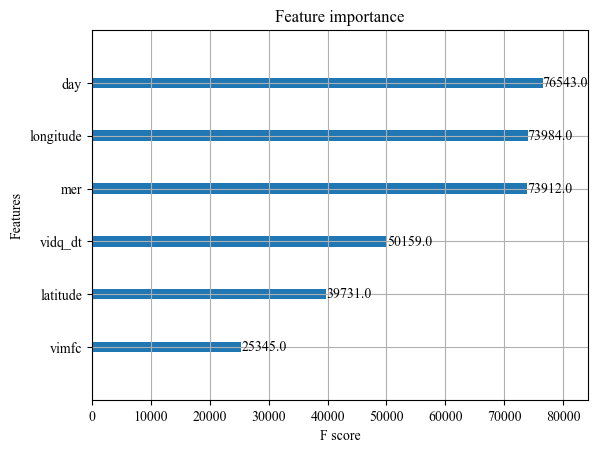

In [20]:
plot_importance(xgb_model)
plt.show()

# Tuning


## Try to use Bayesian optimization to tuning the model

In [1]:
def bayesian_tuning(X_train, y_train, X_test, y_test, param_test, alg):
    """
    Optimize XGBoost hyperparameters using Bayesian Optimization.

    Returns:
    ---------
    dict
        Best parameters and model performance metrics
    """

    param_space = param_test
    model = alg
    optimizer = BayesSearchCV(
        model,
        param_space,
        n_iter = 20,
        cv = 4,
        verbose = 1,
        n_jobs = -1
    )

    optimizer.fit(X_train, y_train)
    
    best_params = optimizer.best_params_
    best_model =xgb.XGBRegressor(**best_params, random_state=42)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    test_score = mean_squared_error(y_test, y_pred, squared=False)

    optimizer.fit(X_train, y_train)
    results = {
        'best_params': optimizer.best_params_,
        'rmse': test_score,
        'best_model': best_model
    }

    return results
    
    

In [21]:
param_test = {
    'n_estimators': Integer(450, 650),
    'learning_rate': Real(0.01, 0.1),
    'max_depth': Integer(10,15),
    'gamma': Real(0, 1),
    'min_child_weight': Integer(12,18)
}

results = bayesian_tuning(training_X, training_y, testing_X, testing_y, param_test, xgb_reg)
print("\nBest Parameters:")
for param, value in results['best_params'].items():
    print(f"{param}: {value}")
print(f"\nBest CV Score: {results['best_score_cv']:.4f}")
print(f"Test Accuracy: {results['test_accuracy']:.4f}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:15:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:15:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:15:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:15:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:15:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:15:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:31:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:31:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:32:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:32:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:32:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:32:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:46:55] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:46:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi


Best Parameters:
gamma: 0.012883868384600653
learning_rate: 0.0882823902110968
max_depth: 12
min_child_weight: 12
n_estimators: 453


KeyError: 'best_score_cv'

In [55]:
params = {
    'learning_rate': 0.09,
    'n_estimators': 450,
    'max_depth': 12,
    'min_child_weight': 12,
    'subsample': 0.55,
    'gamma': 0.032,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device' : 'cuda'
}

In [56]:
xgb_reg = xgb.XGBRegressor(**params, seed = 42)
y_pred, xgb_model = run_model(xgb_reg, training_X, testing_X, training_y, testing_y)

RMSE:  0.00452225324029777
R^2:  0.8223210481644131


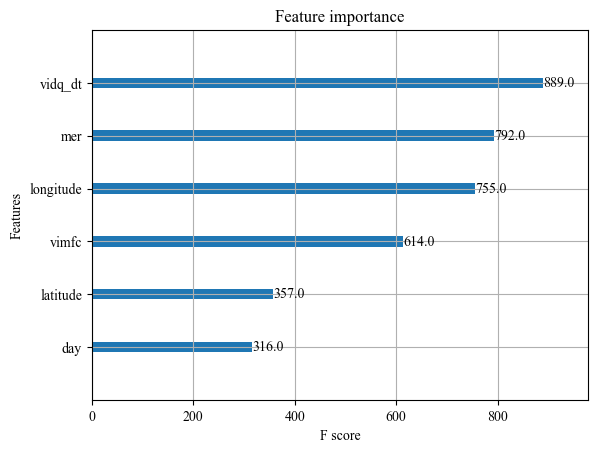

In [57]:
plot_importance(xgb_model)
plt.show()

In [43]:
def tuning_function(alg, param_test, training_X, training_y):
    """
    Tune the hyperparameters of the model
    
    Parameters:
    -----------
    alg: xgboost model
        The xgboost model to be trained
    param_test: dict
        The hyperparameters to be tuned
    training_X: pd dataframe
        The training data
    training_y: pd dataframe
        The training label
    
    return: dict
        The best hyperparameters
    """
    gsearch = GridSearchCV(estimator = alg, 
                           param_grid = param_test, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1,
                           verbose=1,
                           cv=4)
    
    gsearch.fit(training_X, training_y)

    print("Best parameters found: ", gsearch.best_params_)
    print("Lowest RMSE found: ", np.sqrt(np.abs(gsearch.best_score_)))

    new_params = alg.get_xgb_params()
    for key in gsearch.best_params_.keys():
        new_params[key] = gsearch.best_params_[key]

    alg = xgb.XGBRegressor(**new_params)

    return alg, gsearch.cv_results_

In [44]:
def plot_gridsearch(grid, results, folds=4):

    x = np.arange(0,len(results['params']))

    fig = plt.figure(figsize=(16,4))
    ax = plt.subplot(111)
    cols=sns.color_palette("cubehelix",folds)

    for i in range(4):  

        plt.scatter(x=x,y=results['split{}_test_score'.format(i)],
                        color=cols[i],edgecolor='grey',s=50,
                        alpha=0.5,label='Fold {}'.format(i+1))
        plt.plot(x,results['split{}_test_score'.format(i)],
                 color=cols[i])

    plt.scatter(x=x,y=results['mean_test_score'],
                    color='black',edgecolor='grey',s=50,
                    alpha=0.5,label='Mean')
    plt.plot(x,results['mean_test_score'],
             color='black')

    plt.ylabel('RMSE')

    k = list(results['params'][0].keys())
    if len(k) > 1: 
        labels = ['{}:{} \n {}:{}'.format(k[0],
                                            results['params'][i][k[0]],
                                            k[1],
                                            results['params'][i][k[1]],
                                           ) for i in range(len(results['params']))]

        plt.xlabel('Parameters')
        plt.xticks(x, labels,rotation=90)
    else:
        plt.xlabel(k[0])
        plt.xticks(x, grid[k[0]])

    plt.legend()

In [45]:
# gamma
grid_3 = {'gamma': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]}
xgb_reg, results_3 = tuning_function(xgb_reg, grid_3, training_X, training_y)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:21:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:21:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Best parameters found:  {'gamma': 0.04}
Lowest RMSE found:  0.004474650476618781


In [46]:
results_3

{'mean_fit_time': array([137.47883773,  39.44650102,  38.46021163,  34.99034125,
         34.70543969,  33.99331158,  33.97970444]),
 'std_fit_time': array([0.17207977, 0.02780472, 0.30177084, 0.21169182, 0.08233323,
        0.30696161, 0.05803725]),
 'mean_score_time': array([0.71399033, 0.51688957, 0.50190276, 0.43394661, 0.43601441,
        0.44360948, 0.48424166]),
 'std_score_time': array([0.12003823, 0.0340521 , 0.0398134 , 0.02535407, 0.01420368,
        0.02193108, 0.00407283]),
 'param_gamma': masked_array(data=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'gamma': 0},
  {'gamma': 0.02},
  {'gamma': 0.04},
  {'gamma': 0.06},
  {'gamma': 0.08},
  {'gamma': 0.1},
  {'gamma': 0.12}],
 'split0_test_score': array([-2.29079952e-05, -1.90285609e-05, -1.90377956e-05, -1.92928839e-05,
        -1.94092950e-05, -1.95582275e-05, -1.97318482e-05]),
 'split1_test_score': array([-1.86472

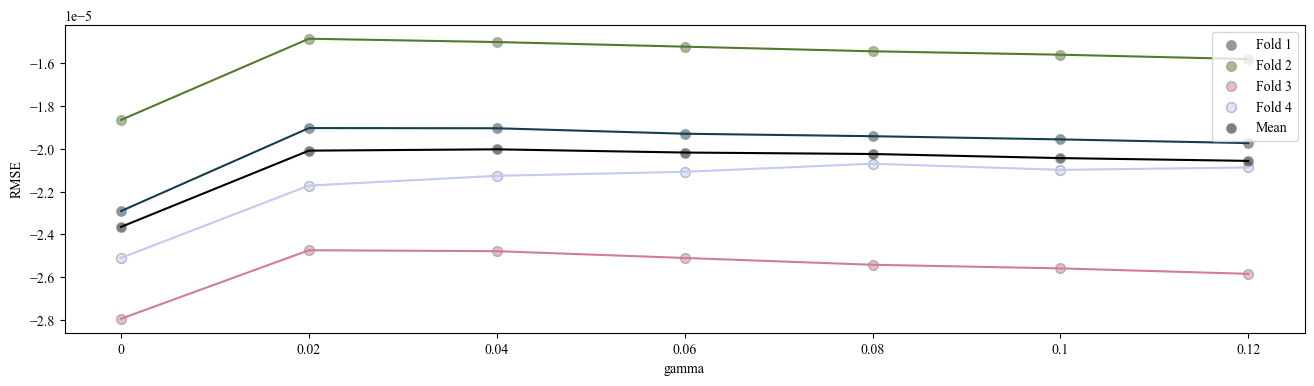

In [47]:
plot_gridsearch(grid_3, results_3)

In [51]:
# gamma
grid_4 = {'gamma': [0.012, 0.016, 0.02, 0.024, 0.028, 0.032]}
xgb_reg, results_4 = tuning_function(xgb_reg, grid_4, training_X, training_y)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:51:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:51:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Best parameters found:  {'gamma': 0.032}
Lowest RMSE found:  0.004469040118137674


In [53]:
results_4

{'mean_fit_time': array([37.5480938 , 36.99346226, 36.69672948, 34.53850091, 34.75718385,
        34.48306382]),
 'std_fit_time': array([0.51342354, 0.57979819, 0.34766217, 0.24665701, 0.06889677,
        0.03189427]),
 'mean_score_time': array([0.4280647 , 0.44545841, 0.46056277, 0.45425195, 0.45090193,
        0.41236025]),
 'std_score_time': array([0.00862918, 0.01911299, 0.01218439, 0.03648598, 0.04002733,
        0.05055434]),
 'param_gamma': masked_array(data=[0.012, 0.016, 0.02, 0.024, 0.028, 0.032],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'gamma': 0.012},
  {'gamma': 0.016},
  {'gamma': 0.02},
  {'gamma': 0.024},
  {'gamma': 0.028},
  {'gamma': 0.032}],
 'split0_test_score': array([-1.92260069e-05, -1.89003833e-05, -1.90285609e-05, -1.89727586e-05,
        -1.89431446e-05, -1.89039998e-05]),
 'split1_test_score': array([-1.47739152e-05, -1.47583002e-05, -1.48523503e-05, -1.48932302e-05,
        -1.49300653e-05, -1.4

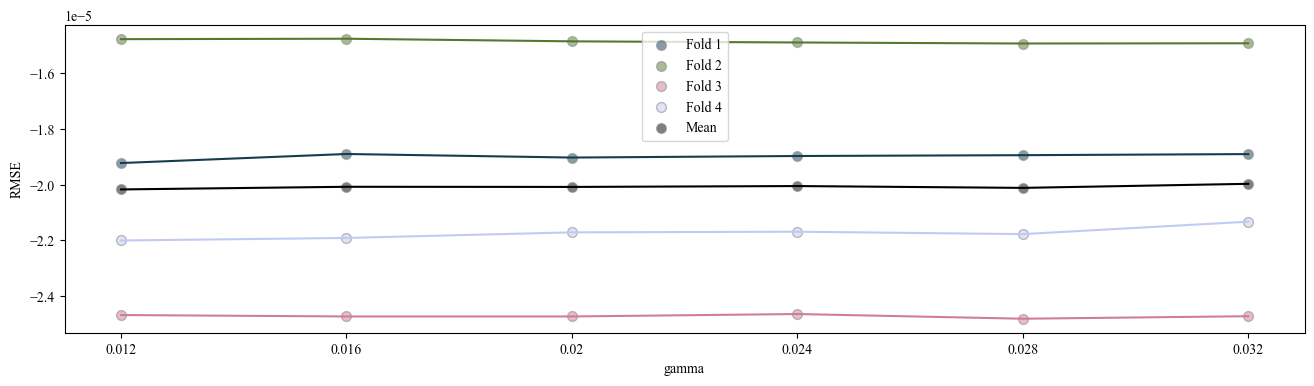

In [54]:
plot_gridsearch(grid_4, results_4)

In [ ]:
xgb.plot_tree(xgb_model, num_trees=0)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()